# **Tecnológico de Costa Rica**

![TEC](https://www.eslared.net/sites/default/files/2020-06/tec_logo.png)


***IC-4213 / Inteligencia artificial***

Autores


*   **Sebastian Matey Rodriguez**
*   **Liz Iveth Salazar Salazar**
*   **Roosevelt Alejandro Pérez González**

# Análisis del Problema

El problema de predicción del precio del aguacate es esencialmente una serie temporal con fuerte estacionalidad semanal/anual, heterogeneidad por región y tipo, y relaciones no lineales entre precio, volúmenes y mezcla de bolsas, además de alta multicolinealidad entre variables de volumen. Para capturar esta estructura, se construyen lags y promedios móviles del precio, señales de calendario (mes, semana del año, trimestre) y proporciones de bolsas que sustituyen combinaciones redundantes. Dado este contexto, el algoritmo elegido es CatBoostRegressor(Gradient Boosting de árboles), porque modela bien no linealidades e interacciones, maneja categóricas de forma nativa sin one-hot y su ordered boosting reduce el leakage en validaciones temporales, además, con early stopping y un split cronológico (train/valid/test) entrega un desempeño estable y competitivo para este tipo de datos.


# Entendimiento de los Datos

## Carga de los datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
file_path = "/content/avocado.csv"
df = pd.read_csv(file_path)
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


# Entendimiento de los Datos

## Analisis de los datos

In [3]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


In [4]:
df.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [5]:
# Verificar la cantidad de valores nulos en cada columna
print("Missing values in Dataset:")
print(df.isnull().sum())

Missing values in Dataset:
Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64


In [6]:
# Verificar duplicados
print(f"Duplicados en el dataset: {df.duplicated().sum()}")

Duplicados en el dataset: 0


El conjunto tiene 18 249 registros y 14 columnas sin faltantes ni duplicados, lo que indica buena calidad de datos para modelar. "AveragePrice" presenta un valor medio 1.41, con cola alta en precios grandes. Las variables de volumen y de bolsas muestran escalas muy desiguales y claros sesgos, lo que sugiere transformaciones logarítmicas y/o uso de proporciones para estabilizar. Hay tres categóricas clave ("region", "type", y la fecha actualmente como texto) que conviene convertir a "datetime".


## Distribuciones

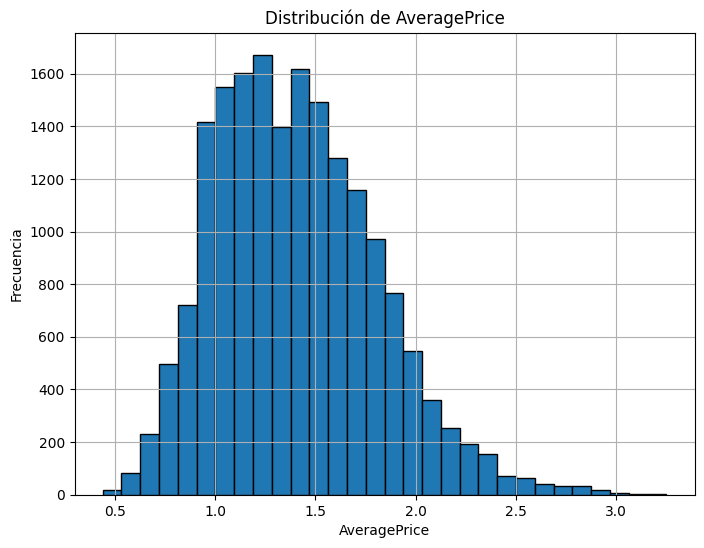

In [7]:
# Histograma de distribución del precio
plt.figure(figsize=(8,6))
df['AveragePrice'].hist(bins=30, edgecolor='black')
plt.title("Distribución de AveragePrice")
plt.xlabel("AveragePrice")
plt.ylabel("Frecuencia")
plt.show()

/tmp/ipython-input-1684986381.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = tmp.set_index('Date').resample('M').mean()


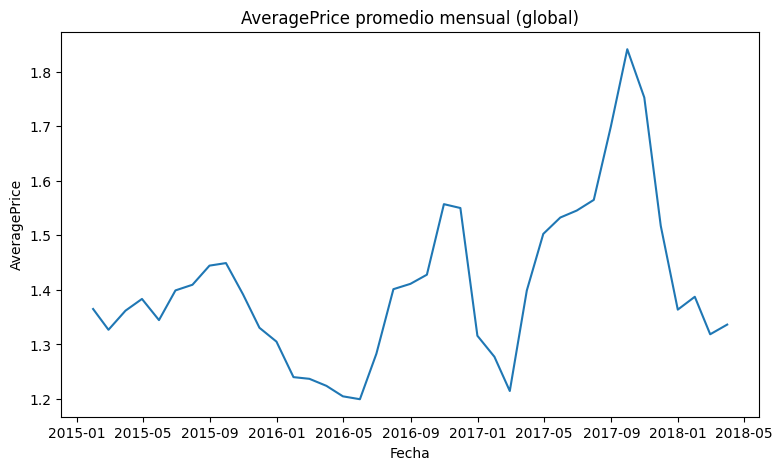

In [8]:
# Tendencia temporal mensual (promedio global)
tmp = df[['Date','AveragePrice']].copy()
tmp['Date'] = pd.to_datetime(tmp['Date'], errors='coerce')
m = tmp.set_index('Date').resample('M').mean()

plt.figure(figsize=(9,5))
plt.plot(m.index, m['AveragePrice'])
plt.title("AveragePrice promedio mensual (global)")
plt.xlabel("Fecha")
plt.ylabel("AveragePrice")
plt.show()


<Figure size 1200x600 with 0 Axes>

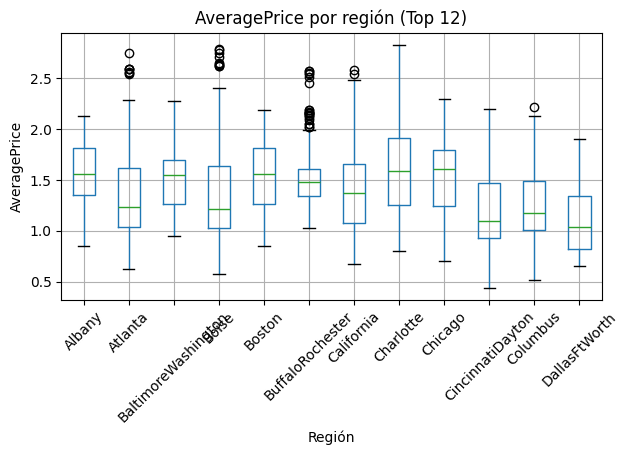

In [9]:
# Variabilidad por región
top = df['region'].value_counts().head(12).index
sub = df[df['region'].isin(top)].copy()

plt.figure(figsize=(12,6))
sub.boxplot(column='AveragePrice', by='region', rot=45)
plt.title("AveragePrice por región (Top 12)")
plt.suptitle("")
plt.xlabel("Región")
plt.ylabel("AveragePrice")
plt.tight_layout()
plt.show()


La distribución de "AveragePrice" es unimodal con ligera asimetría a la derecha, esto nos dice que la mayoría de los precios se concentran entre 1.1 y 1.7 USD, pero existen colas hacia valores altos (≥2.3) que explican picos esporádicos. El promedio mensual global muestra una estacionalidad marcada, con valles a inicios de año y picos hacia el tercer–cuarto trimestre, particularmente en 2017, coherente con ciclos de oferta y demanda. Por región se observa heterogeneidad, lo que significa que las medianas difieren de forma notoria entre mercados y la dispersión también algunas ciudades exhiben cajas más altas y bigotes largos con outliers, mientras que otras mantienen rangos más contenidos y medianas menores.


## Matriz de correlación

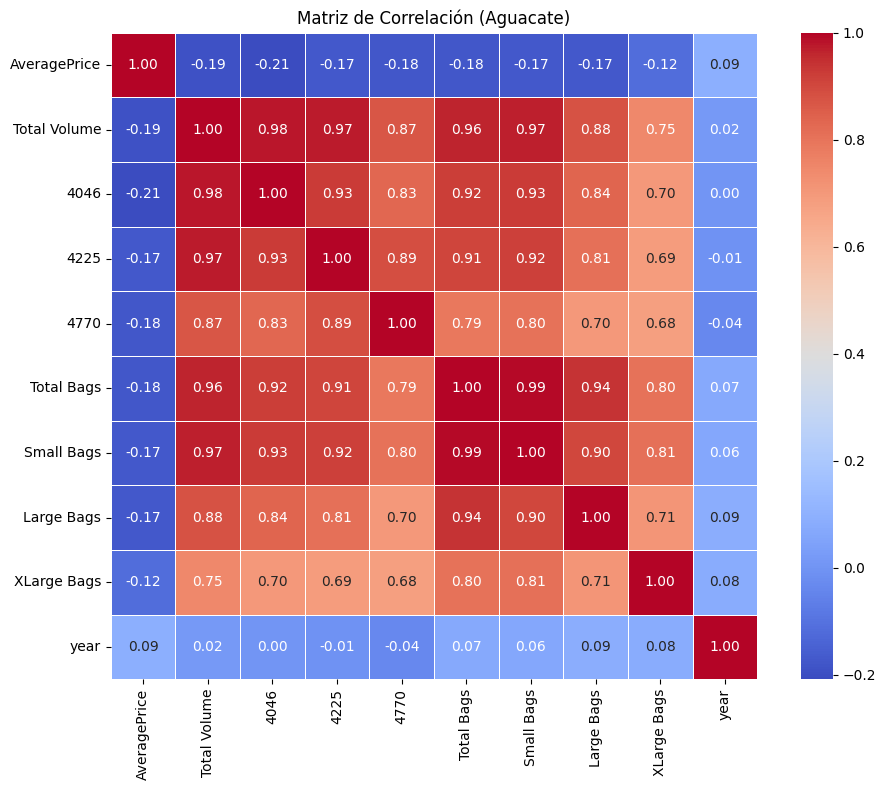

In [10]:
# Selecciona solo columnas numéricas relevantes (ajusta si lo necesitas)
num_cols = [
    "AveragePrice","Total Volume","4046","4225","4770",
    "Total Bags","Small Bags","Large Bags","XLarge Bags","year"
]
num_cols = [c for c in num_cols if c in df.columns]

# Asegura que sean numéricas
df_num = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Calcula la matriz de correlación
corr = df_num.corr()

# Visualización tipo heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, square=True)
plt.title("Matriz de Correlación (Aguacate)")
plt.tight_layout()
plt.show()

La matriz confirma una multicolinealidad muy alta entre las variables de cantidad, "Total Volume", los PLU ("4046/4225/4770") y las bolsas "Total/Small/Large/XLarge Bags" están fuertemente correlacionadas entre sí (0.70–0.99), lo que indica que gran parte de la información es redundante. En cambio, el precio ("AveragePrice") muestra correlaciones débiles y negativas con esos volúmenes (−0.12 a −0.21), señal de que cuando circula más producto el precio tiende a bajar, pero no de manera lineal fuerte. La variable "year" casi no se asocia con el resto (−0.04 a 0.09), por lo que la estacionalidad debería capturarse con features más finas (mes/semana, lags).


# Modelo de Machine Learning

## Preparación de los datos

In [11]:
# Preparación de datos para CatBoost
# - Limpieza y parseo de fechas
# - Features de calendario
# - Ratios de bolsas (evitan colinealidad)
# - Transformaciones log1p
# - Lags y rolling means del precio (sin fuga: shift(1))
# - Lags de volumen
# - Partición temporal por grupo (train/val/test)
# Devuelve: df_feat, feature_cols, cat_features

def prepare_catboost_avocado(df: pd.DataFrame,
                             val_weeks: int = 26,
                             test_weeks: int = 26):
    df = df.copy()

    # --- 1) Limpieza básica ---
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])
    if not np.issubdtype(df["Date"].dtype, np.datetime64):
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    df = df.sort_values(["region", "type", "Date"]).reset_index(drop=True)

    # --- 2) Calendario ---
    df["year"]           = df["Date"].dt.year.astype("int16")
    df["month"]          = df["Date"].dt.month.astype("int8")
    df["weekofyear"]     = df["Date"].dt.isocalendar().week.astype("int16")
    df["quarter"]        = df["Date"].dt.quarter.astype("int8")
    df["dayofweek"]      = df["Date"].dt.dayofweek.astype("int8")
    df["is_month_start"] = df["Date"].dt.is_month_start.astype("int8")
    df["is_month_end"]   = df["Date"].dt.is_month_end.astype("int8")

    # --- 3) Ratios de bolsas ---
    eps = 1e-9
    df["small_ratio"]  = (df["Small Bags"]  / (df["Total Volume"] + eps)).astype("float32")
    df["large_ratio"]  = (df["Large Bags"]  / (df["Total Volume"] + eps)).astype("float32")
    df["xlarge_ratio"] = (df["XLarge Bags"] / (df["Total Volume"] + eps)).astype("float32")

    # --- 4) Logs para variables sesgadas ---
    for col in ["Total Volume", "4046", "4225", "4770", "Total Bags"]:
        df[f"log1p_{col.replace(' ', '_')}"] = np.log1p(df[col]).astype("float32")

    # --- 5) Lags y rolling means (sin fuga) por (region,type) ---
    group_cols = ["region", "type"]
    target_col = "AveragePrice"

    lags  = [1, 4, 12, 52]
    rolls = [4, 12, 52]

    for L in lags:
        df[f"{target_col}_lag_{L}"] = df.groupby(group_cols)[target_col].shift(L).astype("float32")

    for W in rolls:
        df[f"{target_col}_roll_mean_{W}"] = (
            df.groupby(group_cols)[target_col]
              .transform(lambda s: s.shift(1).rolling(window=W,
                                                      min_periods=max(2, int(W*0.6))).mean())
            .astype("float32")
        )

    for L in [1, 4, 12]:
        df[f"TotalVolume_lag_{L}"] = df.groupby(group_cols)["Total Volume"].shift(L).astype("float32")

    # --- 6) Quitar filas con NaN creados por lags/rollings ---
    na_cols = [c for c in df.columns if ("lag_" in c) or ("roll_mean_" in c)]
    df = df.dropna(subset=na_cols).reset_index(drop=True)

    # --- 7) Partición temporal vectorizada por grupo ---
    last_date = df.groupby(group_cols)["Date"].transform("max")
    test_cut  = last_date - pd.Timedelta(weeks=test_weeks)
    val_cut   = test_cut  - pd.Timedelta(weeks=val_weeks)

    df["set"] = "train"
    df.loc[(df["Date"] > val_cut) & (df["Date"] <= test_cut), "set"] = "val"
    df.loc[df["Date"] > test_cut, "set"] = "test"

    # --- 8) Columnas finales (¡SIN duplicar categóricas!) ---
    cat_features = ["region", "type"]  # para CatBoost
    num_features = [
        "year","month","weekofyear","quarter","dayofweek","is_month_start","is_month_end",
        "Total Volume","small_ratio","large_ratio","xlarge_ratio",
        "log1p_Total_Volume","log1p_4046","log1p_4225","log1p_4770","log1p_Total_Bags",
    ] + [f"{target_col}_lag_{L}" for L in lags] \
      + [f"{target_col}_roll_mean_{W}" for W in rolls] \
      + [f"TotalVolume_lag_{L}" for L in [1, 4, 12]]

    # Mantener solo los num_features existentes
    num_features = [c for c in num_features if c in df.columns]

    # Para entrenar: cat + num (esta lista se usará como X)
    feature_cols = cat_features + num_features

    # Para el DataFrame final: columnas base + SOLO num_features (region/type ya van aparte)
    base_cols = ["Date","region","type","set",target_col]
    df_feat = df[base_cols + num_features].copy()

    # Categóricas como string y columnas únicas (cinturón y tirantes)
    for c in cat_features:
        df_feat[c] = df_feat[c].astype(str)
    df_feat = df_feat.loc[:, ~df_feat.columns.duplicated()].copy()

    return df_feat, feature_cols, cat_features


df_feat, feature_cols, cat_features = prepare_catboost_avocado(df)

print(df_feat["set"].value_counts().to_frame("rows"))
print("Features totales:", len(feature_cols), "| Categóricas:", cat_features)


       rows
set        
train  7019
test   2808
val    2806
Features totales: 28 | Categóricas: ['region', 'type']


## Entrenamiento

In [12]:
# Entrenamiento CatBoost

!pip install -q catboost

import pandas as pd
from catboost import CatBoostRegressor, Pool

target = "AveragePrice"
cat_names = ["region","type"]

train_df = df_feat[df_feat["set"]=="train"].copy()
val_df   = df_feat[df_feat["set"]=="val"].copy()

X_train = train_df[feature_cols].copy()
y_train = train_df[target].copy()
X_val   = val_df[feature_cols].copy()
y_val   = val_df[target].copy()

# Chequeos rápidos (opcionales)
assert not pd.Index(X_train.columns).duplicated().any()
assert list(X_train.columns) == list(X_val.columns)

# Categóricas como string
X_train[cat_names] = X_train[cat_names].astype(str)
X_val[cat_names]   = X_val[cat_names].astype(str)

train_pool = Pool(X_train, y_train, cat_features=cat_names)
val_pool   = Pool(X_val,   y_val,   cat_features=cat_names)

model = CatBoostRegressor(
    loss_function="MAE",
    eval_metric="MAE",
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    iterations=5000,
    random_seed=42,
    verbose=0
)
model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=200)
print("Mejor iteración:", model.get_best_iteration())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00
Mejor iteración: 630


## Evaluación

In [13]:
# Gráficas de evaluación para CatBoost
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import Pool

target    = "AveragePrice"
cat_names = ["region","type"]
feat_cols = feature_cols

# Seguridad anti-duplicados
df_feat = df_feat.loc[:, ~df_feat.columns.duplicated()].copy()

# Conjuntos
val_df  = df_feat[df_feat["set"]=="val"].copy()
test_df = df_feat[df_feat["set"]=="test"].copy()

# Matrices de features
X_val  = val_df[feat_cols].copy()
X_test = test_df[feat_cols].copy()
X_val[cat_names]  = X_val[cat_names].astype(str)
X_test[cat_names] = X_test[cat_names].astype(str)

y_val  = val_df[target].to_numpy()
y_test = test_df[target].to_numpy()

val_pool  = Pool(X_val,  y_val,  cat_features=cat_names)
test_pool = Pool(X_test, y_test, cat_features=cat_names)

# Predicciones
pred_val  = model.predict(val_pool)
pred_test = model.predict(test_pool)

# Métricas rápidas
def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-9, None)))
    return mae, rmse, mape

mae_v, rmse_v, mape_v = metrics(y_val,  pred_val)
mae_t, rmse_t, mape_t = metrics(y_test, pred_test)
print(f"[VAL ] MAE={mae_v:.4f} | RMSE={rmse_v:.4f} | MAPE={100*mape_v:.2f}%")
print(f"[TEST] MAE={mae_t:.4f} | RMSE={rmse_t:.4f} | MAPE={100*mape_t:.2f}%")

# DataFrames de predicción para diagnóstico
def build_pred_df(df_part, preds):
    out = df_part[["Date","region","type",target]].copy()
    out["region"] = out["region"].astype(str)
    out["type"]   = out["type"].astype(str)
    out["pred"]    = preds
    out["resid"]   = out[target] - out["pred"]
    out["abs_err"] = out["resid"].abs()
    out["ape"]     = out["abs_err"] / np.clip(out[target].abs(), 1e-9, None)
    return out

val_pred  = build_pred_df(val_df,  pred_val)
test_pred = build_pred_df(test_df, pred_test)


[VAL ] MAE=0.1380 | RMSE=0.2107 | MAPE=8.08%
[TEST] MAE=0.1181 | RMSE=0.1660 | MAPE=8.21%


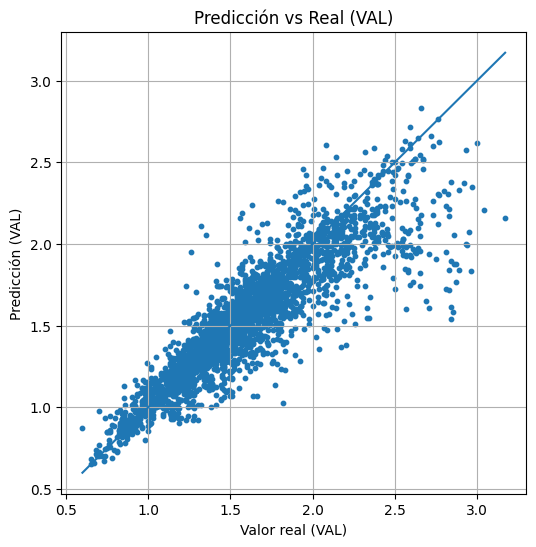

In [14]:
# Scatter y_true vs y_pred
plt.figure(figsize=(6,6))
mn = float(min(y_val.min(), pred_val.min()))
mx = float(max(y_val.max(), pred_val.max()))
plt.scatter(y_val, pred_val, s=10)
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Valor real (VAL)")
plt.ylabel("Predicción (VAL)")
plt.title("Predicción vs Real (VAL)")
plt.grid(True)
plt.show()

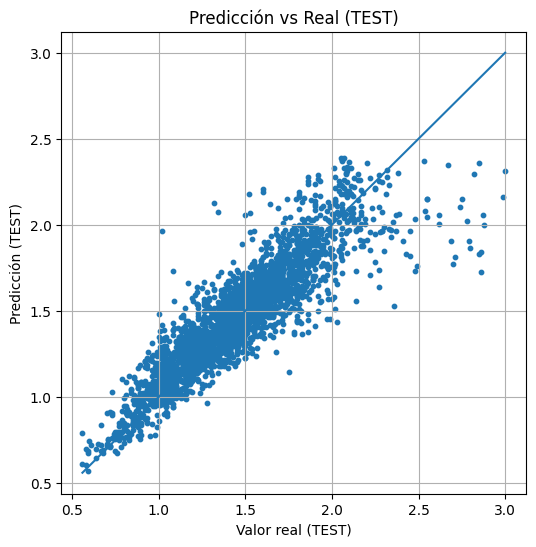

In [15]:
# Scatter y_true vs y_pred
plt.figure(figsize=(6,6))
mn = float(min(y_test.min(), pred_test.min()))
mx = float(max(y_test.max(), pred_test.max()))
plt.scatter(y_test, pred_test, s=10)
plt.plot([mn, mx], [mn, mx])
plt.xlabel("Valor real (TEST)")
plt.ylabel("Predicción (TEST)")
plt.title("Predicción vs Real (TEST)")
plt.grid(True)
plt.show()

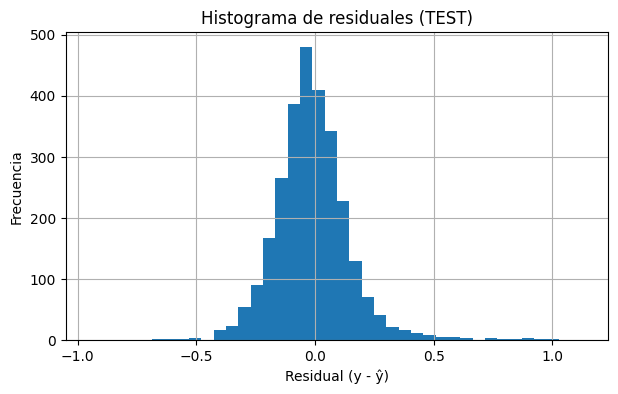

In [16]:
# Histograma de residuales
plt.figure(figsize=(7,4))
plt.hist(test_pred["resid"], bins=40)
plt.xlabel("Residual (y - ŷ)")
plt.ylabel("Frecuencia")
plt.title("Histograma de residuales (TEST)")
plt.grid(True)
plt.show()

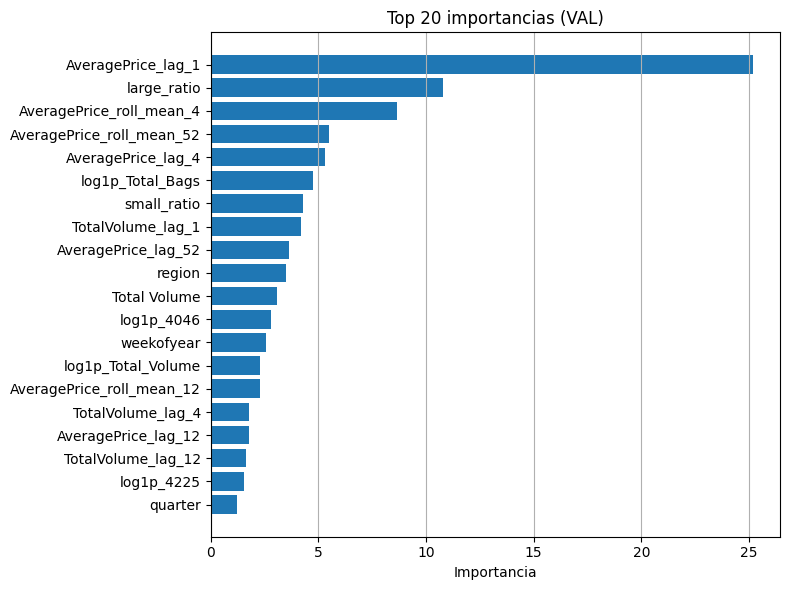

In [17]:
# Importancias de características
imp_val = pd.DataFrame({
    "feature": X_val.columns,
    "importance": model.get_feature_importance(val_pool)
}).sort_values("importance", ascending=False)

topk = 20
plt.figure(figsize=(8,6))
plt.barh(imp_val["feature"].head(topk)[::-1], imp_val["importance"].head(topk)[::-1])
plt.xlabel("Importancia")
plt.title(f"Top {topk} importancias (VAL)")
plt.tight_layout()
plt.grid(True, axis="x")
plt.show()

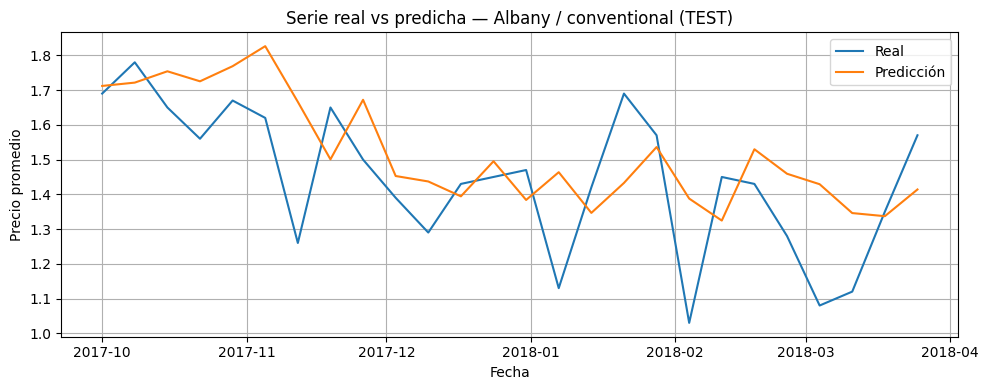

In [18]:
# Serie temporal real vs predicho
gsize = test_pred.groupby(["region","type"])["pred"].size().sort_values(ascending=False)
top_group = gsize.index[0]
gtest = (test_pred[(test_pred["region"]==top_group[0]) & (test_pred["type"]==top_group[1])]
         .sort_values("Date"))

plt.figure(figsize=(10,4))
plt.plot(gtest["Date"], gtest[target], label="Real")
plt.plot(gtest["Date"], gtest["pred"], label="Predicción")
plt.xlabel("Fecha")
plt.ylabel("Precio promedio")
plt.title(f"Serie real vs predicha — {top_group[0]} / {top_group[1]} (TEST)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


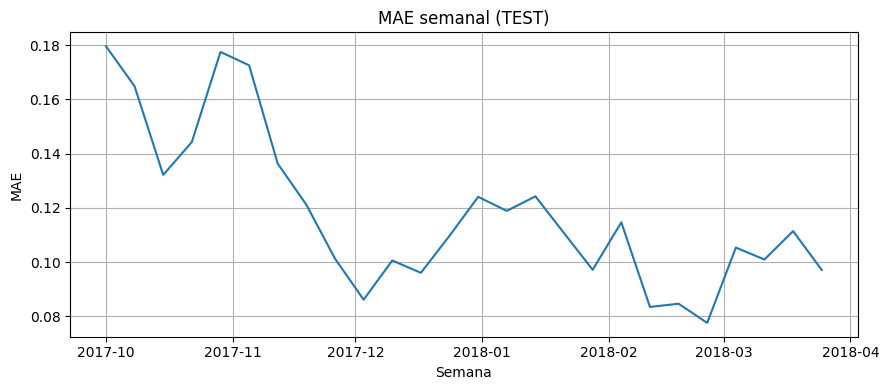

In [19]:
# Curva de desempeño temporal
weekly = (test_pred
          .set_index("Date")
          .groupby(pd.Grouper(freq="W"))
          .agg(MAE=("abs_err","mean")))
plt.figure(figsize=(9,4))
plt.plot(weekly.index, weekly["MAE"])
plt.xlabel("Semana")
plt.ylabel("MAE")
plt.title("MAE semanal (TEST)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Resultados

Los resultados confirman un modelo sólido y estable, con predicción vs. real en validación y prueba se pegan a la diagonal, con una leve tendencia a infraestimar los precios más altos, el histograma de residuales está bien centrado en cero y sólo muestra una cola positiva moderada, lo que sugiere errores sin sesgo fuerte. Las métricas globales son consistentes (VAL MAE=0.138, TEST MAE=0.118, MAPE 8%), señal de buena generalización. Las importancias dominadas por "AveragePrice_lag_1", las medias móviles de 4 y 52 semanas y el large_ratio indican que el modelo explota la memoria de corto plazo, la estacionalidad anual y la composición de tamaños para explicar el precio. En la serie por región se observa que la predicción sigue la forma pero suaviza los picos, y el MAE semanal oscila con estacionalidad (picos a fin de año y mejoras posteriores). En conjunto, el modelo captura bien la dinámica esencial del mercado del aguacate, con margen de mejora puntual en los episodios de precio elevado.


# Guardado del modelo

In [20]:
import pickle

with open("avocado_model.pkl", "wb") as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

print("Modelo CatBoost guardado en catboost_model.pkl")

Modelo CatBoost guardado en catboost_model.pkl
